--- Block 1: Libraries Loaded ---
--- Block 2: Dataset loaded: 700 rows, 34 columns ---
Target variable 'risk scoring' encoded.
A/B/C Feature Sets Defined.
--- Block 3: Preprocessing transformers built ---
--- Block 4: Running Gauntlet: 8 models x 3 feature sets ---

--- Evaluating Feature Set: Minimal ---
  > Logistic Regression: ROC AUC = 0.9269
  > K-Nearest Neighbors: ROC AUC = 0.9360
  > SVM (RBF Kernel): ROC AUC = 0.9593
  > Decision Tree: ROC AUC = 0.8500
  > Random Forest: ROC AUC = 0.9637
  > Gradient Boosting: ROC AUC = 0.9534
  > XGBoost: ROC AUC = 0.9641
  > LightGBM: ROC AUC = 0.9612

--- Evaluating Feature Set: Extended (Raw) ---
  > Logistic Regression: ROC AUC = 0.8974
  > K-Nearest Neighbors: ROC AUC = 0.8057
  > SVM (RBF Kernel): ROC AUC = 0.9093
  > Decision Tree: ROC AUC = 0.8240
  > Random Forest: ROC AUC = 0.9300
  > Gradient Boosting: ROC AUC = 0.9379
  > XGBoost: ROC AUC = 0.9473
  > LightGBM: ROC AUC = 0.9369

--- Evaluating Feature Set: Extended (Engineered) -

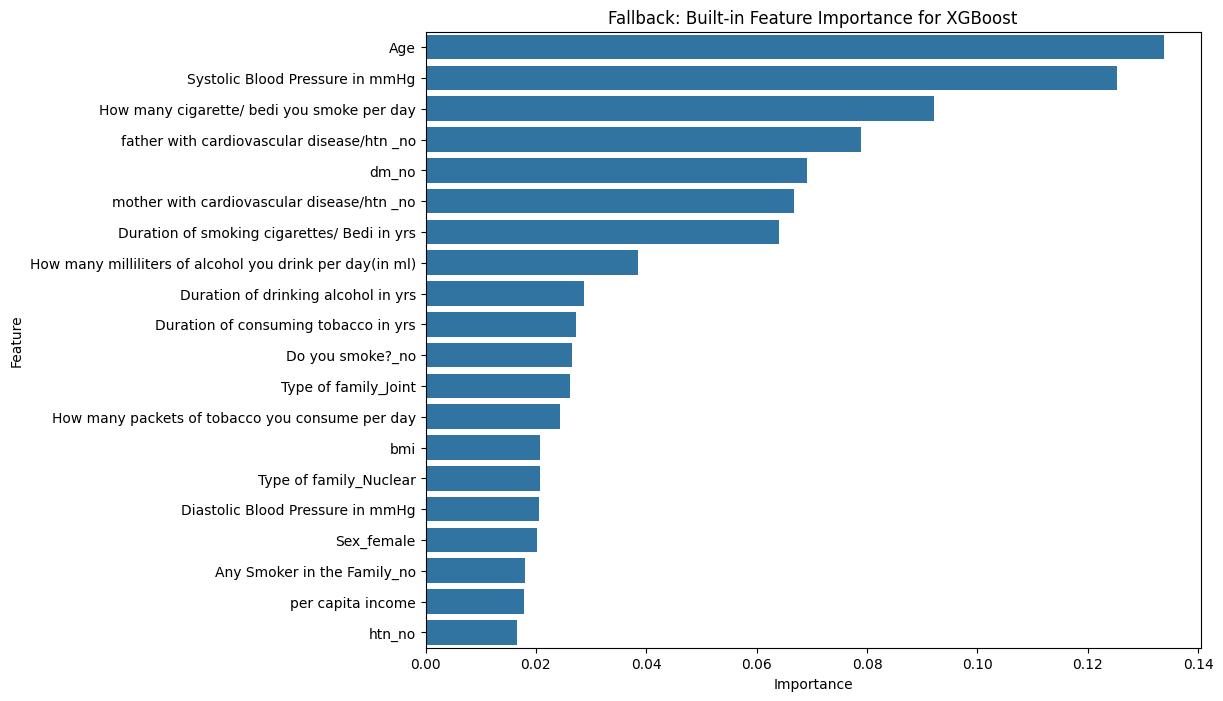


--- Block 6: Generating Final Results ---

--- Results Table 1: Minimal Feature Set ---
  Feature Set            Algorithm  ROC AUC (OvR)  F1 (Weighted)  Accuracy  \
6     Minimal              XGBoost         0.9641         0.8700    0.8714   
4     Minimal        Random Forest         0.9637         0.8643    0.8686   
7     Minimal             LightGBM         0.9612         0.8597    0.8600   
2     Minimal     SVM (RBF Kernel)         0.9593         0.8105    0.7957   
5     Minimal    Gradient Boosting         0.9534         0.8648    0.8671   
1     Minimal  K-Nearest Neighbors         0.9360         0.8003    0.8114   
0     Minimal  Logistic Regression         0.9269         0.7750    0.7629   
3     Minimal        Decision Tree         0.8500         0.8509    0.8500   

   Precision (Weighted)  Recall (Weighted)  Total Time (s)  
6                0.8743             0.8714          1.3258  
4                0.8646             0.8686          2.2555  
7                0.8643  

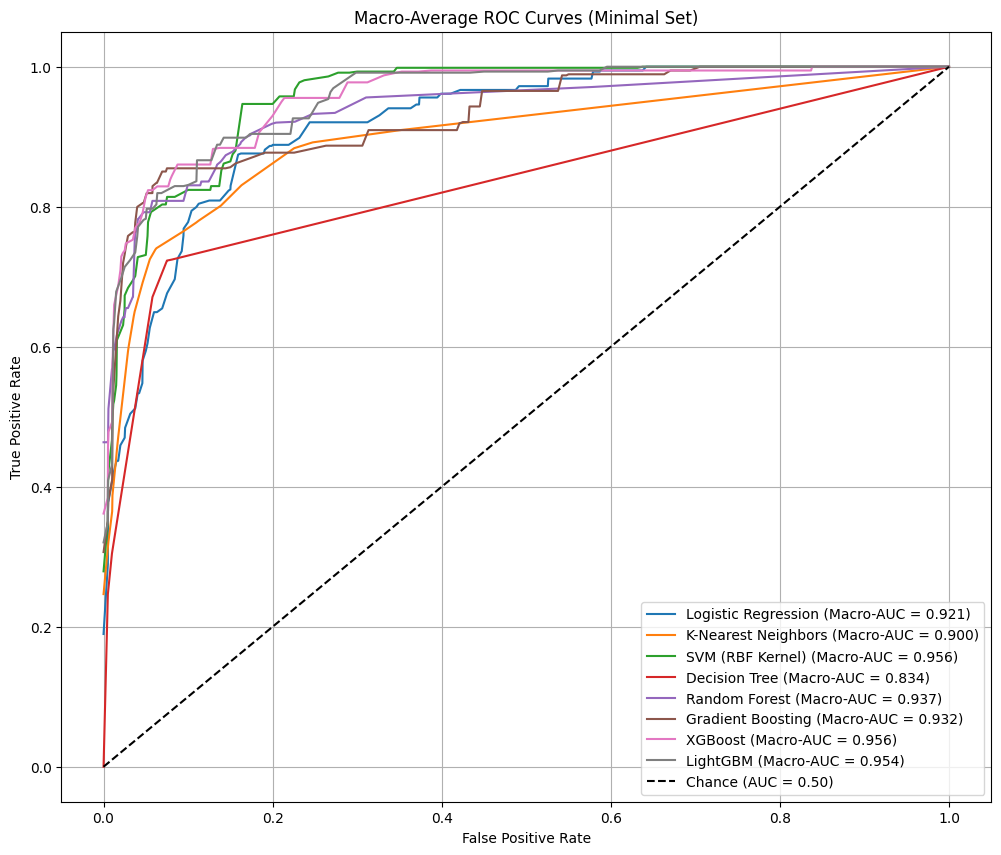


... Plotting for Feature Set: Extended (Raw) ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 40
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

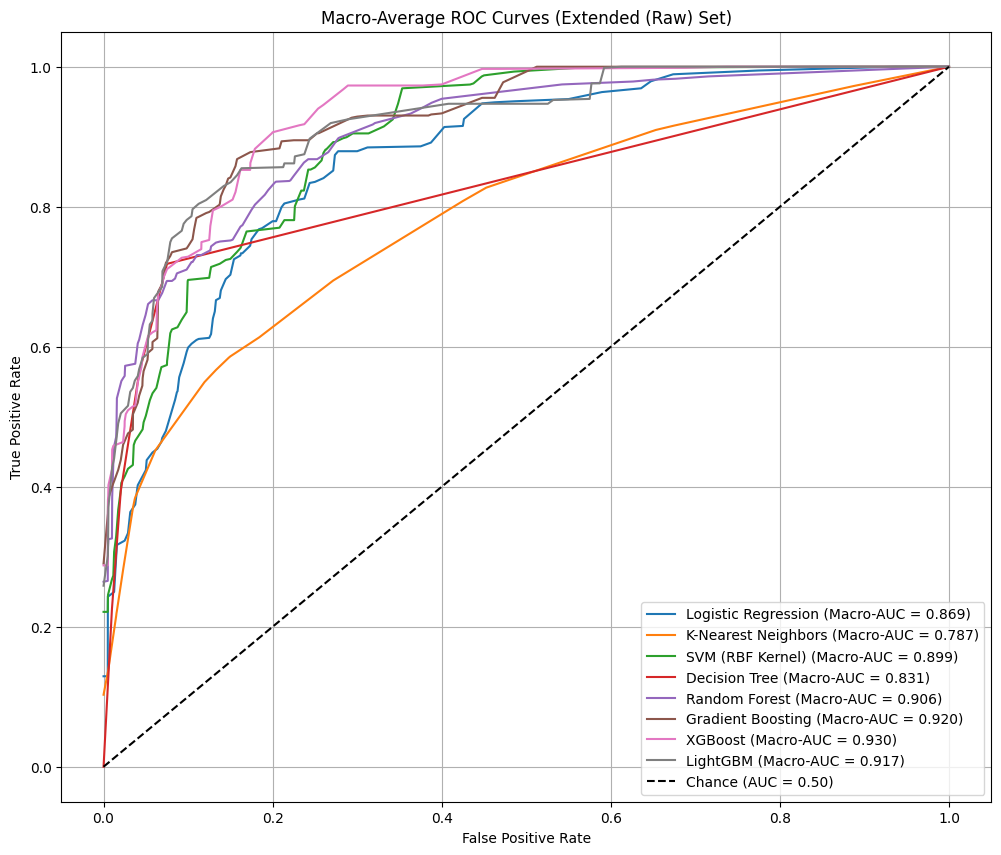


... Plotting for Feature Set: Extended (Engineered) ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 37
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

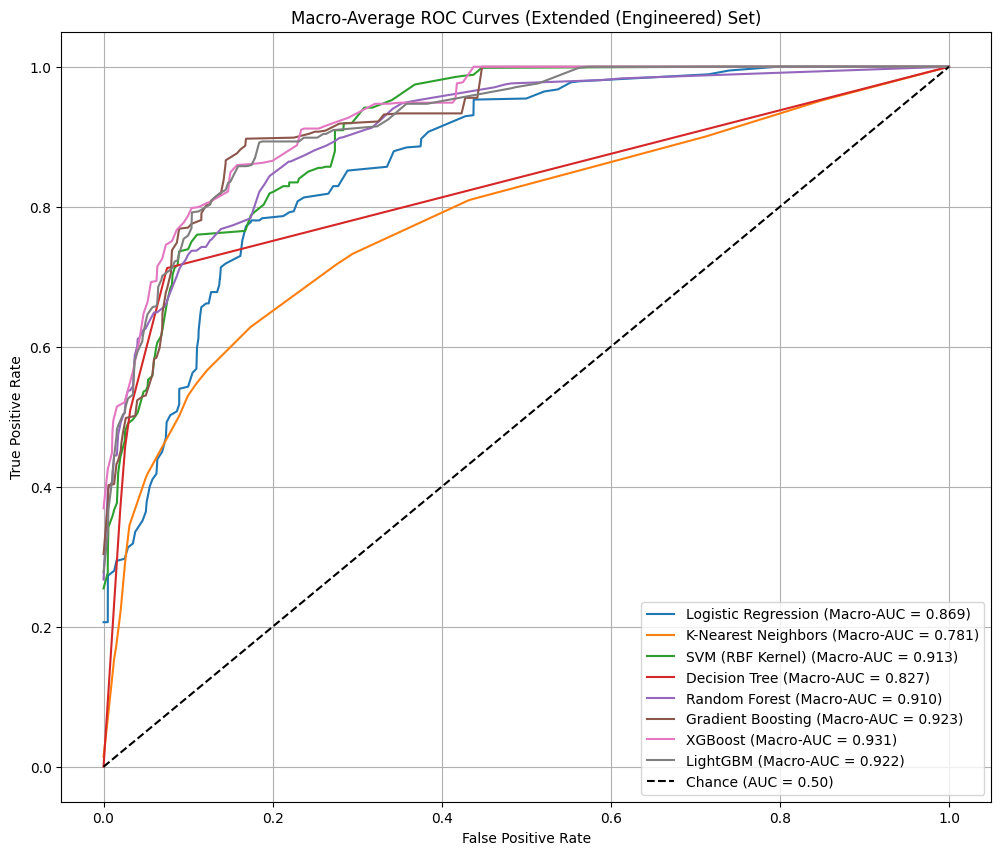


--- ALL BLOCKS COMPLETE ---


In [2]:
# ----------------------------------------
# BLOCK 1: SETUP (THE ARSENAL)
# ----------------------------------------
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, auc, roc_curve
from sklearn.preprocessing import label_binarize

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

!pip install shap -q
import shap

print("--- Block 1: Libraries Loaded ---")


# ----------------------------------------
# BLOCK 2: LOAD AND PREPARE DATA (THE A/B/C TEST)
# ----------------------------------------
try:
    df = pd.read_csv('Classification ML model data MI - Sheet1.csv')
    print(f"--- Block 2: Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns ---")
except FileNotFoundError:
    print("Error: 'Classification ML model data MI - Sheet1.csv' not found.")
    print("Please upload the file to your Colab session.")
    raise

# --- 1. Target Variable Engineering ---
target_col = 'risk scoring'
if df[target_col].isnull().any():
    print(f"Warning: Found {df[target_col].isnull().sum()} missing target values. Dropping these rows.")
    df = df.dropna(subset=[target_col])

le = LabelEncoder()
y = le.fit_transform(df[target_col])
target_names = le.classes_
print(f"Target variable '{target_col}' encoded.")

# --- 2. Feature Engineering ---
X = df.drop(columns=[target_col, 'sl no'])

# Set A: Minimal
minimal_features = [
    'Age', 'Sex', 'Systolic Blood Pressure in mmHg', 'dm', 'Do you smoke?'
]

# Define engineered and raw features
engineered_features = ['per capita income', 'bmi', 'WHR']
raw_component_features = [
    'Total Family Income per month', 'Total Family Members',
    'Height in metres', 'Weight in kg',
    'Waist circumference in cm', 'Hip circumference in cm'
]
all_features = list(X.columns)

# Set B: Extended (Raw)
extended_features_raw = [
    col for col in all_features if col not in engineered_features
]

# Set C: Extended (Engineered)
extended_features_engineered = [
    col for col in all_features if col not in raw_component_features
]

categorical_features = X.select_dtypes(include=['object', 'category']).columns
numeric_features = X.select_dtypes(include=np.number).columns

print("A/B/C Feature Sets Defined.")


# ----------------------------------------
# BLOCK 3: BUILD THE PREPROCESSING PIPELINE (THE ENGINE)
# ----------------------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
print("--- Block 3: Preprocessing transformers built ---")


# ----------------------------------------
# BLOCK 4: RUN THE GAUNTLET (THE A/B/C EXPERIMENT)
# ----------------------------------------
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7),
    'SVM (RBF Kernel)': SVC(probability=True, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced')
}

feature_sets = {
    "Minimal": minimal_features,
    "Extended (Raw)": extended_features_raw,
    "Extended (Engineered)": extended_features_engineered
}

scoring_metrics = {
    'Accuracy': 'accuracy',
    'F1 (Weighted)': 'f1_weighted',
    'Precision (Weighted)': 'precision_weighted',
    'Recall (Weighted)': 'recall_weighted',
    'ROC AUC (OvR)': 'roc_auc_ovr'
}

results_list = []

print(f"--- Block 4: Running Gauntlet: {len(models)} models x {len(feature_sets)} feature sets ---")

for set_name, features in feature_sets.items():
    print(f"\n--- Evaluating Feature Set: {set_name} ---")
    features_present = [col for col in features if col in X.columns]
    X_subset = X[features_present]
    subset_numeric_features = [col for col in features_present if col in numeric_features]
    subset_categorical_features = [col for col in features_present if col in categorical_features]

    subset_preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, subset_numeric_features),
            ('cat', categorical_transformer, subset_categorical_features)
        ],
        remainder='passthrough'
    )

    for model_name, model in models.items():
        start_time = time.time()
        pipeline = Pipeline(steps=[('preprocessor', subset_preprocessor), ('classifier', model)])
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        try:
            cv_results = cross_validate(
                pipeline, X_subset, y, cv=cv, scoring=scoring_metrics, n_jobs=-1
            )
            total_time = time.time() - start_time
            results_list.append({
                'Feature Set': set_name, 'Algorithm': model_name,
                'Fit Time (s)': cv_results['fit_time'].mean(),
                'Score Time (s)': cv_results['score_time'].mean(),
                'Total Time (s)': total_time,
                'Accuracy': cv_results['test_Accuracy'].mean(),
                'F1 (Weighted)': cv_results['test_F1 (Weighted)'].mean(),
                'Precision (Weighted)': cv_results['test_Precision (Weighted)'].mean(),
                'Recall (Weighted)': cv_results['test_Recall (Weighted)'].mean(),
                'ROC AUC (OvR)': cv_results['test_ROC AUC (OvR)'].mean(),
            })
            print(f"  > {model_name}: ROC AUC = {cv_results['test_ROC AUC (OvR)'].mean():.4f}")
        except Exception as e:
            print(f"  > FAILED: {model_name} with error: {e}")

print("\n--- Gauntlet Complete ---")
results_df = pd.DataFrame(results_list) # <-- This is where results_df is created
results_df = results_df.sort_values(by=['Feature Set', 'ROC AUC (OvR)'], ascending=[True, False])
columns_ordered = [
    'Feature Set', 'Algorithm', 'ROC AUC (OvR)', 'F1 (Weighted)', 'Accuracy',
    'Precision (Weighted)', 'Recall (Weighted)', 'Total Time (s)'
]
results_df = results_df[columns_ordered]


# ----------------------------------------
# BLOCK 5: FIND THE "ALPHA" (THE "WHY" WITH SHAP)
# ----------------------------------------
print("\n--- Block 5: Running SHAP Analysis ---")

try:
    best_model_name = results_df[results_df['Feature Set'] == 'Extended (Engineered)'].iloc[0]['Algorithm']
    print(f"Identified best model: {best_model_name} from 'Extended (Engineered)' set.")
except IndexError:
    print("Error: Could not find a best model. Exiting SHAP.")
    best_model_name = None # Set to None to skip SHAP

if best_model_name:
    best_features = extended_features_engineered
    X_best_subset = X[best_features]
    best_numeric_features = [col for col in best_features if col in numeric_features]
    best_categorical_features = [col for col in best_features if col in categorical_features]

    best_preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, best_numeric_features),
            ('cat', categorical_transformer, best_categorical_features)
        ],
        remainder='passthrough'
    )
    best_model_pipeline = Pipeline(steps=[
        ('preprocessor', best_preprocessor),
        ('classifier', models[best_model_name])
    ])
    best_model_pipeline.fit(X_best_subset, y)
    print("Best model pipeline fitted.")

    preprocessor_fitted = best_model_pipeline.named_steps['preprocessor']
    X_preprocessed = preprocessor_fitted.transform(X_best_subset)

    try:
        feature_names = preprocessor_fitted.get_feature_names_out()
        feature_names = [name.split('__')[-1] for name in feature_names]
    except Exception:
        cat_features_out = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(best_categorical_features)
        feature_names = best_numeric_features + list(cat_features_out)

    X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

    model_to_explain = best_model_pipeline.named_steps['classifier']

    try:
        explainer = shap.TreeExplainer(model_to_explain)
        shap_values = explainer.shap_values(X_preprocessed_df)
        print("SHAP values calculated. Generating plots...")

        print("\nDisplaying Plot 1: Global Feature Importance (Bar Chart)")
        plt.title("SHAP: Global Feature Importance (Mean Absolute Impact)")
        shap.summary_plot(
            shap_values, X_preprocessed_df, plot_type="bar",
            class_names=target_names, max_display=20
        )
        plt.show()

        high_risk_index = np.where(le.classes_ == 'high')[0][0]
        print(f"\nDisplaying Plot 2: SHAP Summary (Beeswarm) for '{le.classes_[high_risk_index]}' risk")
        plt.title(f"SHAP: Feature Impact on '{le.classes_[high_risk_index]}' Risk")
        shap.summary_plot(
            shap_values[high_risk_index], X_preprocessed_df, max_display=20
        )
        plt.show()

    except Exception as e:
        print(f"Could not generate SHAP plot for {best_model_name}. Error: {e}")
        if hasattr(model_to_explain, 'feature_importances_'):
            importances = model_to_explain.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_names, 'Importance': importances
            }).sort_values(by='Importance', ascending=False).head(20)
            plt.figure(figsize=(10, 8))
            sns.barplot(data=importance_df, x='Importance', y='Feature')
            plt.title(f'Fallback: Built-in Feature Importance for {best_model_name}')
            plt.show()


# ----------------------------------------
# BLOCK 6: CONSOLIDATED RESULTS (Tables and Plots)
# ----------------------------------------
print("\n--- Block 6: Generating Final Results ---")

# --- 1. PERFORMANCE METRICS TABLES ---
print("\n--- Results Table 1: Minimal Feature Set ---")
print(results_df[results_df['Feature Set'] == 'Minimal'].round(4))

print("\n--- Results Table 2: Extended (Raw) Feature Set ---")
print(results_df[results_df['Feature Set'] == 'Extended (Raw)'].round(4))

print("\n--- Results Table 3: Extended (Engineered) Feature Set ---")
print(results_df[results_df['Feature Set'] == 'Extended (Engineered)'].round(4))

# --- 2. AUC ROC CURVE PLOTS ---
print("\n--- Generating AUC ROC Curve Plots ---")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

for set_name, features in feature_sets.items():
    print(f"\n... Plotting for Feature Set: {set_name} ...")
    plt.figure(figsize=(12, 10))

    features_present = [col for col in features if col in X.columns]
    X_train_subset = X_train[features_present]
    X_test_subset = X_test[features_present]
    subset_numeric_features = [col for col in features_present if col in numeric_features]
    subset_categorical_features = [col for col in features_present if col in categorical_features]

    subset_preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, subset_numeric_features),
            ('cat', categorical_transformer, subset_categorical_features)
        ],
        remainder='passthrough'
    )

    for model_name, model in models.items():
        try:
            pipeline = Pipeline(steps=[('preprocessor', subset_preprocessor), ('classifier', model)])
            pipeline.fit(X_train_subset, y_train)
            y_prob = pipeline.predict_proba(X_test_subset)

            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

            mean_tpr /= n_classes
            macro_auc = auc(all_fpr, mean_tpr)
            plt.plot(all_fpr, mean_tpr, label=f'{model_name} (Macro-AUC = {macro_auc:.3f})')
        except Exception as e:
            print(f"    > Could not plot {model_name}. Error: {e}")

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Macro-Average ROC Curves ({set_name} Set)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(f'roc_plot_{set_name.replace(" ", "_")}.png', dpi=300)
    plt.show()

print("\n--- ALL BLOCKS COMPLETE ---")